In [1]:
import os
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import rasterio
import supervision as sv
from ultralytics import YOLO
import torch

## Task 1

#### DATA EXPLORATION AND UNDERSTANDING

### Functions

In [2]:
# PART 1

def linc(file_paths, folder_path):
    # finding all files inside the folders
    dic = {}
    for file in file_paths:
        file_path = os.path.join(folder_path, file)
        with open(file_path, "r", encoding="utf-8") as f:
            line_count = sum(1 for line in f)  # Count lines in the file
        dic[line_count] = dic.get(line_count, 0) + 1
    return dic

# PART 2

def get_area(file_path,size,tile_id):
    areas = []
    with open(file_path,"r") as file:
        lines = file.readlines()
    for l in lines:
        data = l.strip().split()
        x_center, y_center, x_width, y_width = map(float, data[1:])
        x_min, pixel_width, _, y_max, _, pixel_height = Tiles[tile_id-1]
        # Convert normalized width & height to pixels
        abs_width = x_width * size[0]
        abs_height = y_width * size[1]

        # Convert pixel values to meters using EPSG:32633
        width_meters = abs_width * pixel_width
        height_meters = abs_height * abs(pixel_height)  # Use abs() since height is negative
        area_meters_squared = width_meters * height_meters
        areas.append(area_meters_squared)
    return areas

In [4]:
#file paths
hd_folder_path = "C:/Users/samra/OneDrive/Desktop/SRIP task/dataset/labels_hd"
native_folder_path = "C:/Users/samra/OneDrive/Desktop/SRIP task/dataset/labels_native"
txt_files_hd = [f for f in os.listdir(hd_folder_path) if f.endswith(".txt")]
txt_files_native = [f for f in os.listdir(native_folder_path) if f.endswith(".txt")]

# image sizes
native = (416,416)
hd = (832,832)

# sorting dictionaries
hd_sat_dic = sorted(linc(txt_files_hd, hd_folder_path).items(), key=lambda item: item[1])
native_sat_dic = sorted(linc(txt_files_native, native_folder_path).items(), key=lambda item: item[1])

# Tile id values
Tiles=[(307670.04, 0.31, 0.0, 5434427.100000001, 0.0, -0.31),(312749.07999999996, 0.31, 0.0, 5403952.860000001, 0.0, -0.31),(312749.07999999996, 0.31, 0.0, 5363320.540000001, 0.0, -0.31)]

# Part 1

a)

In [5]:
merged_dict = defaultdict(int)

# Add values from both dictionaries
for d in (hd_sat_dic, native_sat_dic):
    for key, value in d:
        merged_dict[key] += value  # Add values

merged_dict = sorted(merged_dict.items(),key=lambda item: item[0])

tot = 0
for k, v in merged_dict:
    tot += v*k

print(f"Total instances of solar panel: {tot}")

for k, v in merged_dict:
    print(f"{v} files with {k} labels")

Total instances of solar panel: 59505
163 files with 1 labels
337 files with 2 labels
423 files with 3 labels
447 files with 4 labels
436 files with 5 labels
391 files with 6 labels
341 files with 7 labels
348 files with 8 labels
344 files with 9 labels
253 files with 10 labels
194 files with 11 labels
161 files with 12 labels
142 files with 13 labels
102 files with 14 labels
88 files with 15 labels
78 files with 16 labels
68 files with 17 labels
55 files with 18 labels
58 files with 19 labels
27 files with 20 labels
10 files with 21 labels
5 files with 22 labels
8 files with 23 labels
6 files with 24 labels
5 files with 25 labels
10 files with 26 labels
9 files with 27 labels
9 files with 28 labels
36 files with 29 labels
29 files with 30 labels
15 files with 31 labels
13 files with 32 labels
21 files with 33 labels
39 files with 34 labels
20 files with 35 labels
20 files with 36 labels
32 files with 37 labels
32 files with 38 labels
18 files with 39 labels
19 files with 40 labels
18 

# Part 2

The pixel coordinates may be translated to geocoordinates using the EPSG:32633 coordinate system using the given geotransform for each tile.

    Width (in m) = pixel_width * length_width(in pixels)
    Length (in m) = pixel_length * length_length(in pixels)
    *Note: These values are given according to tile id

# a) Function to get area

In [6]:
def get_area(file_path,size,tile_id):
    areas = []
    with open(file_path,"r") as file:
        lines = file.readlines()
    for l in lines:
        data = l.strip().split()
        x_center, y_center, x_width, y_width = map(float, data[1:])
        x_min, pixel_width, _, y_max, _, pixel_height = Tiles[tile_id-1]
        # Convert normalized width & height to pixels
        abs_width = x_width * size[0]
        abs_height = y_width * size[1]

        # Convert pixel values to meters using EPSG:32633
        width_meters = abs_width * pixel_width
        height_meters = abs_height * abs(pixel_height)  # Use abs() since height is negative
        area_meters_squared = width_meters * height_meters
        areas.append(area_meters_squared)
    return areas

## Getting area for all the native images

Mean area:  191.51782786497893
Standard deviation of area:  630.7003355500087


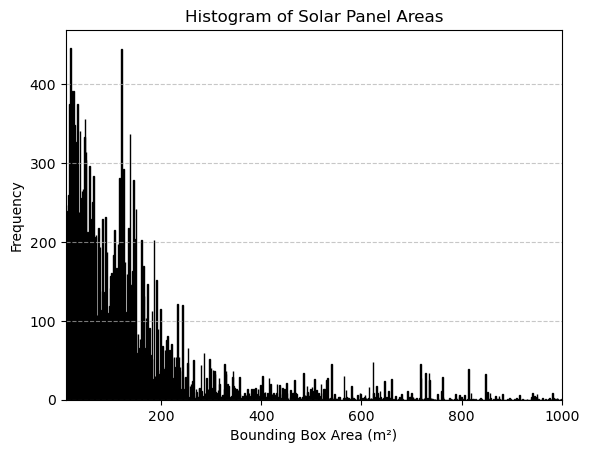

In [8]:
areas = []

for f in txt_files_native:
    if "native_1" in f:
        tile_id = 1
    if "native_2" in f:
        tile_id = 2
    if "native_3" in f:
        tile_id = 3
    file_path = os.path.join(native_folder_path, f)
    areas = areas + get_area(file_path,native,tile_id)

# if you want to get area of hd files as well
# for f in  txt_files_hd:
#     if "hd_1" in f:
#         tile_id = 1
#     if "hd_2" in f:
#         tile_id = 2
#     if "hd_3" in f:
#         tile_id = 3
#     file_path = os.path.join(hd_folder_path, f)
#     areas = areas + get_area(file_path,hd,tile_id)

areas = np.array(areas)

mean_area = np.mean(areas)
standard_deviation = np.std(areas)
print("Mean area: ",mean_area)
print("Standard deviation of area: ",standard_deviation)

plt.hist(areas, bins=10000, color='skyblue', edgecolor='black')
plt.xlim(10, 1000)
plt.xlabel("Bounding Box Area (m²)")
plt.ylabel("Frequency")
plt.title("Histogram of Solar Panel Areas")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## It is Seen that no. of panels drop exponentially as bounding area increases
### majority of solar panels have size range (0,200)

# Task 2

## Defining functions

In [9]:
# for part 1
def IoU(predicted,groundtruth):
    pred_box = Polygon([
        (predicted[0], predicted[1]), (predicted[2], predicted[1]),
        (predicted[2], predicted[3]), (predicted[0], predicted[3])
    ])
    
    gt_box = Polygon([
        (groundtruth[0], groundtruth[1]), (groundtruth[2], groundtruth[1]),
        (groundtruth[2], groundtruth[3]), (groundtruth[0], groundtruth[3])
    ])
    
    # Compute intersection and union areas
    intersection_area = pred_box.intersection(gt_box).area
    union_area = pred_box.union(gt_box).area

    # Avoid division by zero
    if union_area == 0:
        return 0.0
    
    # Compute IoU
    iou = intersection_area / union_area
    return iou

# for part 2

def compute_precision_recall(gt_boxes, pred_boxes, pred_scores, iou_threshold=0.5):
    """
    Compute precision and recall given ground truth and predicted bounding boxes.
    """
    # Sort predicted boxes by confidence score
    sorted_indices = np.argsort(np.concatenate(pred_scores))[::-1]
    pred_boxes = [pred_boxes[i // len(pred_boxes[0])][i % len(pred_boxes[0])] for i in sorted_indices]

    tp = np.zeros(len(pred_boxes))
    fp = np.zeros(len(pred_boxes))
    matched = set()

    for i, pred_box in enumerate(pred_boxes):
        best_iou = 0
        best_gt_idx = -1

        for gt_idx, gt_box_list in enumerate(gt_boxes):
            for gt_box in gt_box_list:
                iou = IoU(pred_box, gt_box)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = gt_idx

        if best_iou >= iou_threshold and best_gt_idx not in matched:
            tp[i] = 1  # True Positive
            matched.add(best_gt_idx)
        else:
            fp[i] = 1  # False Positive

    tp_cumsum = np.cumsum(tp)
    fp_cumsum = np.cumsum(fp)

    precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
    recalls = tp_cumsum / len(gt_boxes)

    return recalls, precisions

def voc11(recalls,precisions):
    recalls = np.array(recalls)
    precisions = np.array(precisions)
    
    recall_levels = np.linspace(0, 1, 11)
    
    # Interpolated precision values
    interpolated_precisions = []
    
    for recall_level in recall_levels:
        precisions_above_recall = precisions[recalls >= recall_level]
        if precisions_above_recall.size > 0:
            interpolated_precisions.append(np.max(precisions_above_recall))
        else:
            interpolated_precisions.append(0)
    
    # Compute the mean of the interpolated precision values (11-point interpolation AP)
    ap = np.mean(interpolated_precisions)
    return ap

def coco_ap_101_point_interpolation(recalls, precisions):

    recalls = np.array(recalls)
    precisions = np.array(precisions)
    
    recall_levels = np.linspace(0, 1, 101)
    interpolated_precisions = []
    
    for recall_level in recall_levels:
        precisions_above_recall = precisions[recalls >= recall_level]
        if precisions_above_recall.size > 0:
            interpolated_precisions.append(np.max(precisions_above_recall))
        else:
            interpolated_precisions.append(0)
    
    ap = np.mean(interpolated_precisions)
    return ap

def compute_ap_pr_curve(recalls, precisions):

    return np.trapz(precisions, recalls) 

def generate_boxes(num_images=10, img_size=100, box_size=20):
    gt_boxes = []
    pred_boxes = []
    conf_scores = []
    
    for _ in range(num_images):
        gt = [
            (random.randint(0, img_size - box_size), random.randint(0, img_size - box_size),
             random.randint(0, img_size - box_size) + box_size, random.randint(0, img_size - box_size) + box_size)
            for _ in range(10)
        ]
        pred = [
            (random.randint(0, img_size - box_size), random.randint(0, img_size - box_size),
             random.randint(0, img_size - box_size) + box_size, random.randint(0, img_size - box_size) + box_size)
            for _ in range(10)
        ]
        scores = [max(IoU(p, g) for g in gt) for p in pred]
        
        gt_boxes.append(gt)
        pred_boxes.append(pred)
        conf_scores.append(scores)
    
    return gt_boxes, pred_boxes, conf_scores

def compute_ap_50(gt_boxes, pred_boxes, conf_scores, method = "pr-curve"):
    aps = []
    for gt, pred, scores in zip(gt_boxes, pred_boxes, conf_scores):
        ious = np.array([[IoU(p, g) for g in gt] for p in pred])
        
        tp = np.zeros(len(pred))
        fp = np.zeros(len(pred))
        matched = set()
        
        for i, _ in enumerate(pred):
            best_gt_idx = np.argmax(ious[i])
            if ious[i][best_gt_idx] >= 0.5 and best_gt_idx not in matched:
                tp[i] = 1
                matched.add(best_gt_idx)
            else:
                fp[i] = 1
        
        tp_cumsum = np.cumsum(tp)
        fp_cumsum = np.cumsum(fp)
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
        recalls = tp_cumsum / len(gt)
        
        if method == "pr-curve":
            ap = compute_ap_pr_curve(recalls, precisions)
        elif method == "voc-11":
            ap = voc11(recalls, precisions)
        elif method == "coco-101":
            ap = coco_ap_101_point_interpolation(recalls, precisions)
        else:
            raise ValueError("Invalid method. Choose from 'pr-curve', 'voc-11', or 'coco-101'.")
        
        aps.append(ap)
    
    return np.mean(aps)

# Part 1

In [10]:
## test for comparing with super vision

# Example 1: Partial overlap
pred_box1 = (10, 10, 50, 50)
gt_box1 = (20, 20, 60, 60)

iou1 = IoU(pred_box1, gt_box1)
sv_iou1 = sv.box_iou_batch(np.array([pred_box1]),np.array([gt_box1]))[0]

print("IoU (Example 1):", iou1, "Supervision IoU:", sv_iou1)  # (14.28% overlap)

# Example 2: Perfect match (IoU = 1)
pred_box2 = (30, 30, 70, 70)
gt_box2 = (30, 30, 70, 70)

iou2 = IoU(pred_box2, gt_box2)
sv_iou2 = sv.box_iou_batch(np.array([pred_box2]),np.array([gt_box2]))[0]
print("IoU (Example 2):", iou2, "Supervision IoU:", sv_iou2)  # (100% overlap)

# Example 3: No overlap (IoU = 0)
pred_box3 = (100, 100, 150, 150)
gt_box3 = (200, 200, 250, 250)

iou3 = IoU(pred_box3, gt_box3)
sv_iou3 = sv.box_iou_batch(np.array([pred_box3]),np.array([gt_box3]))[0]
print("IoU (Example 3):", iou3, "Supervision IoU:", sv_iou3)  #(No overlap)

# Example 4: Significant overlap
pred_box4 = (15, 15, 60, 60)
gt_box4 = (25, 25, 65, 65)

iou4 = IoU(pred_box4, gt_box4)
sv_iou4 = sv.box_iou_batch(np.array([pred_box4]),np.array([gt_box4]))[0]
print("IoU (Example 4):", iou4, "Supervision IoU:", sv_iou4)

IoU (Example 1): 0.391304347826087 Supervision IoU: [     0.3913]
IoU (Example 2): 1.0 Supervision IoU: [          1]
IoU (Example 3): 0.0 Supervision IoU: [          0]
IoU (Example 4): 0.5104166666666666 Supervision IoU: [    0.51042]


# Part 2

In [11]:
gt_boxes, pred_boxes, conf_scores = generate_boxes()

recalls, precisions = compute_precision_recall(gt_boxes,pred_boxes,conf_scores)

print("AP50 using VOC 11-point interpolation:", compute_ap_50(gt_boxes, pred_boxes, conf_scores, method="voc-11"))
print("AP50 using COCO 101-point interpolation:", compute_ap_50(gt_boxes, pred_boxes, conf_scores, method="coco-101"))
print("AP50 using PR curve:", compute_ap_50(gt_boxes, pred_boxes, conf_scores, method="pr-curve"))


AP50 using VOC 11-point interpolation: 0.017344871476628162
AP50 using COCO 101-point interpolation: 0.010389749745901029
AP50 using PR curve: 0.004769839656072744


# Task 3

Shuffling and sorting data for YOLO

In [9]:
# ## TASK 3
import shutil

# Paths
data_dir = "C:/Users/samra/OneDrive/Desktop/SRIP task/dataset/image_chips_native"
label_dir = "C:/Users/samra/OneDrive/Desktop/SRIP task/dataset/labels_native"

output_dirs = {
    "train": ("C:/Users/samra/OneDrive/Desktop/SRIP task/data/images/train", "C:/Users/samra/OneDrive/Desktop/SRIP task/data/labels/train"),
    "test": ("C:/Users/samra/OneDrive/Desktop/SRIP task/data/images/test", "C:/Users/samra/OneDrive/Desktop/SRIP task/data/labels/test")
}

# Create output directories if they don't exist
for key, (img_out, lbl_out) in output_dirs.items():
    os.makedirs(img_out, exist_ok=True)
    os.makedirs(lbl_out, exist_ok=True)

# Get all image files (jpg, png, etc.)
valid_extensions = (".tif")
image_files = [f for f in os.listdir(data_dir) if f.endswith(valid_extensions)]

# Filter only those with corresponding txt label files
valid_pairs = []
for img in image_files:
    img_path = os.path.join(data_dir, img)
    txt_path = os.path.join(label_dir, img.replace(os.path.splitext(img)[1], ".txt"))
    
    if os.path.exists(txt_path):
        valid_pairs.append((img_path, txt_path))  # Store valid (image, label) pairs
    else:
        print(f"Skipping {img} (no corresponding label found)")

# Shuffle data before splitting
random.shuffle(valid_pairs)

# Define split ratios
train_ratio, val_ratio = 0.8, 0.2
train_cutoff = int(len(valid_pairs) * train_ratio)

# Split data
train_data = valid_pairs[:train_cutoff]
test_data = valid_pairs[train_cutoff:]

# Function to move files
def move_files(data, category):
    img_dest, lbl_dest = output_dirs[category]
    for img_path, txt_path in data:
        shutil.copy(img_path, os.path.join(img_dest, os.path.basename(img_path)))
        shutil.copy(txt_path, os.path.join(lbl_dest, os.path.basename(txt_path)))

# Move data to respective folders
move_files(train_data, "train")
move_files(test_data, "test")

Skipping solarpanels_native_1__x0_5472_y0_12892_dxdy_416(1).tif (no corresponding label found)
Skipping solarpanels_native_1__x0_7934_y0_8341_dxdy_416(1).tif (no corresponding label found)
Skipping solarpanels_native_1__x0_7934_y0_8347_dxdy_416(1).tif (no corresponding label found)
Skipping solarpanels_native_1__x0_7937_y0_11298_dxdy_416(1).tif (no corresponding label found)
Skipping solarpanels_native_1__x0_7957_y0_8387_dxdy_416(1).tif (no corresponding label found)
Skipping solarpanels_native_1__x0_7958_y0_8403_dxdy_416(1).tif (no corresponding label found)
Skipping solarpanels_native_1__x0_7962_y0_8558_dxdy_416(1).tif (no corresponding label found)
Skipping solarpanels_native_1__x0_7986_y0_11313_dxdy_416(1).tif (no corresponding label found)
Skipping solarpanels_native_1__x0_7997_y0_10765_dxdy_416(1).tif (no corresponding label found)
Skipping solarpanels_native_1__x0_7999_y0_8765_dxdy_416(1).tif (no corresponding label found)
Skipping solarpanels_native_1__x0_7_y0_6959_dxdy_416(1).

Shuffling 10% data of training set for validation

In [14]:
import os
import shutil
import random

# Set paths
train_img_dir = "C:/Users/samra/OneDrive/Desktop/SRIP task/data/images/train"
train_lbl_dir = "C:/Users/samra/OneDrive/Desktop/SRIP task/data/labels/train"
val_img_dir = "C:/Users/samra/OneDrive/Desktop/SRIP task/data/images/val"
val_lbl_dir = "C:/Users/samra/OneDrive/Desktop/SRIP task/data/labels/val"

# Create validation directories if they don't exist
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(val_lbl_dir, exist_ok=True)

# Get all training images
train_images = sorted([f for f in os.listdir(train_img_dir) if f.endswith(('.tif'))])

# Shuffle and select 10% for validation
random.shuffle(train_images)
num_val = max(1, int(0.1 * len(train_images)))  # Ensure at least 1 file is moved
val_images = train_images[:num_val]

# Move selected images and corresponding labels
moved_count = 0
for img in val_images:
    lbl = img.rsplit(".", 1)[0] + ".txt"  # Replace extension with .txt for label file

    img_path = os.path.join(train_img_dir, img)
    lbl_path = os.path.join(train_lbl_dir, lbl)

    if os.path.exists(lbl_path):  # Check if label file exists
        shutil.copy(img_path, os.path.join(val_img_dir, img))
        shutil.copy(lbl_path, os.path.join(val_lbl_dir, lbl))
        moved_count += 1
    else:
        print(f"⚠️ Warning: Label not found for {img}, skipping.")

print(f"✅ Moved {moved_count} images and labels to validation set.")


✅ Moved 203 images and labels to validation set.


## Fitting the model

Handling errors in data

In [17]:
import os

# Define the directory containing label files
label_dir = "C:/Users/samra/OneDrive/Desktop/SRIP task/data/labels/train" # do the same for val and test dir

# Define the category change: Replace category 2 with category 0 (modify as needed)
old_category = "2"
new_category = "0"

# Process all label files
for filename in os.listdir(label_dir):
    if filename.endswith(".txt"):  # Only process .txt files
        file_path = os.path.join(label_dir, filename)

        with open(file_path, "r") as file:
            lines = file.readlines()

        # Modify lines where category is 2
        new_lines = []
        for line in lines:
            parts = line.strip().split()  # Split by space
            if parts and parts[0] == old_category:  # Check if category is 2
                parts[0] = new_category  # Change category
            new_lines.append(" ".join(parts))  # Reconstruct line

        # Save the modified label file
        with open(file_path, "w") as file:
            file.write("\n".join(new_lines) + "\n")

print("Label modification complete!")


Label modification complete!


## Cross checking what category 2 is a legit category or just errors in data


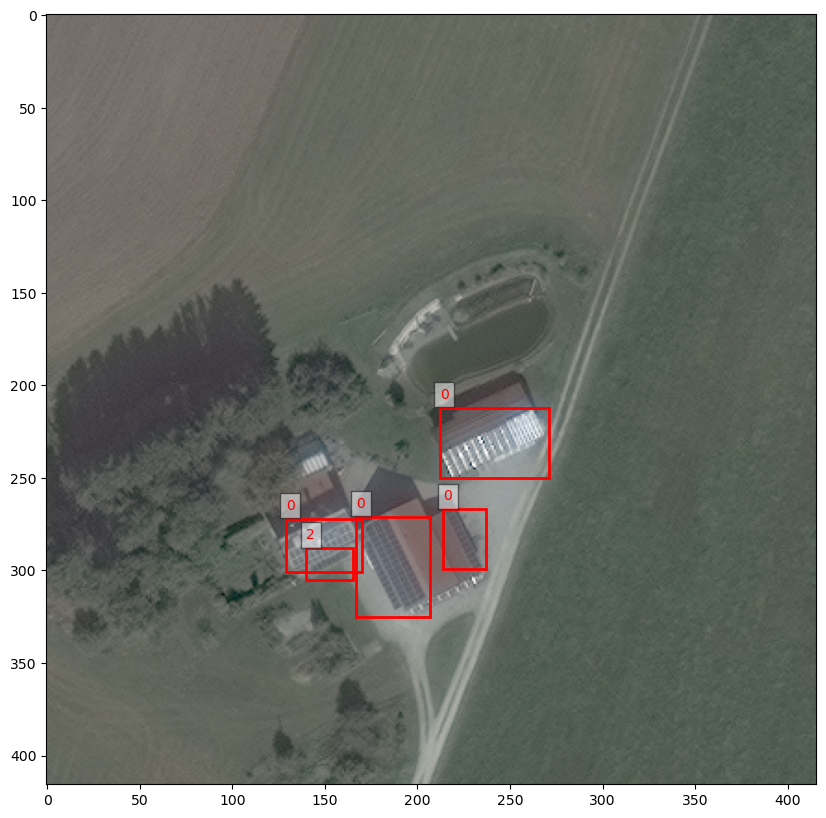

In [26]:

# File paths
tif_path = "C:/Users/samra/OneDrive/Desktop/SRIP task/data/images/train/solarpanels_native_3__x0_6024_y0_8836_dxdy_416.tif"  # Update with your actual file path
txt_path = "C:/Users/samra/OneDrive/Desktop/SRIP task/data/labels/train/solarpanels_native_3__x0_6024_y0_8836_dxdy_416.txt"  # Update with your actual file path

# Open the TIFF image
with rasterio.open(tif_path) as dataset:
    image = dataset.read()  # Read all bands
    height, width = image.shape[1], image.shape[2]  # Get image dimensions

# If the image has at least 3 bands, use RGB (assuming bands 1, 2, 3 are RGB)
if image.shape[0] >= 3:
    image_rgb = np.stack([image[0], image[1], image[2]], axis=-1)  # Convert to (H, W, 3)
else:
    image_rgb = np.squeeze(image)  # Use grayscale if only one band exists

# Normalize for proper display (if necessary)
image_rgb = image_rgb.astype(np.float32)
image_rgb = (image_rgb - np.min(image_rgb)) / (np.max(image_rgb) - np.min(image_rgb))  # Normalize between 0-1

# Read bounding box data from the TXT file
# bboxes = []
# with open(txt_path, "r") as file:
#     for line in file:
#         values = line.strip().split()  # Split line into values
#         if len(values) != 5:
#             continue  # Skip invalid lines
        
#         category, x_center, y_center, x_width, y_height = map(float, values)
        
#         # Convert normalized coordinates to pixel values
#         x_center *= width
#         y_center *= height
#         x_width *= width
#         y_height *= height
        
#         # Convert (center, width, height) to (x_min, y_min, w, h)
#         x_min = x_center - x_width / 2
#         y_min = y_center - y_height / 2
        
#         bboxes.append((x_min, y_min, x_width, y_height, category))

# Plot the image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_rgb)  # Show the image in color

# Draw bounding boxes
for x_min, y_min, x_width, y_height, category in bboxes:
    rect = patches.Rectangle((x_min, y_min), x_width, y_height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x_min, y_min - 5, str(int(category)), color='red', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.show()

## Category 2 appears to be just a miss label

# To be continued in Task3.ipynb